## Introduction

There is no doubt that New York City (NYC), which is also called the City of New York or sometimes simply New York (NY), is the most populous city in the United States. New York is also the most densely populated major city in the United States with an estimated 2018 population of 8,398,748 distributed over about 302.6 square miles (784 km2). The demographics of the city show that it is a large and ethnically diverse metropolis. Starting up a new restaurant in such condense city will be a brilliant idea. This project will explore the best location for opening Arabian restaurant in New York City.

## Data

In order to be able to find the best location for Arabian Restaurant in NYC, data on neighborhoods, boroughs, latitude, longitude, restaurants, and the most common and popular venues will be needed. New York City data containing the neighborhoods and boroughs, latitudes, and longitudes can be obtained from the data source link: https://cocl.us/new_york_dataset. On the other hand, New York City data containing the boundaries of the neighborhood can be obtained from the data source link: https://data.cityofnewyork.us/City-Government/Borough Boundaries/tqmj-j8zm. By using the FourSquare API utilized via the Request library in Python, all data related to locations (GeoSpace Data) and quality of Arabian Restaurants will be obtained. 

## Methodology

Data collection process was started by getting them from the following website link: https://cocl.us/new_york_dataset". After that, venues were found for each neighborhood by using the FourSquare API and Arabian Restaurants were attempted to be filtered out. In addition to that, some individual neighborhoods were explored to get general idea about the venues in the most popular Borough. Next the rankings of the neighborhoods using python's Folium library were visualized. Some mean values were computed to check the most common restaurants in the neighborhoods in general. Finally, k-means clustering algorithm were used to figure out the different prominent location to open a new Arabian Restaurant.

### Improting Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

from bs4 import BeautifulSoup
import os

import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Libraries imported.')

Libraries imported.


### Define some important functions

In [2]:
# function to get the geocodes i.e latitude and longitude of a given location using geopy
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

# function to intract with FourSquare API and get top 100 venues within a radius of 500 metres for a given latitude and longitude
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    CLIENT_ID = ['U21YTTRRLFQ0XHYECE0YS5243NWGNVLN5AHRTFT0LAIPTFKO'] 
    CLIENT_SECRET = ['U2MDVGEXPAM0PEGZSDZN03LY213ROB3GUI0NEWH4530N24UI'] 
    VERSION = '20200420' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
     # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# function to get venue details like like count , rating , tip counts for a given venue id
def get_venue_details(venue_id):
        
    CLIENT_ID = ['U21YTTRRLFQ0XHYECE0YS5243NWGNVLN5AHRTFT0LAIPTFKO'] 
    CLIENT_SECRET = ['U2MDVGEXPAM0PEGZSDZN03LY213ROB3GUI0NEWH4530N24UI']
    VERSION = '20200420'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

new_york_data=get_new_york_data()
new_york_data.shape

(306, 4)

In [3]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### The initial data was obtained as shown above (306 different beighborhoods). Bar chart is a proper selection to visualize and analyze these neighborhoods as shown below.  

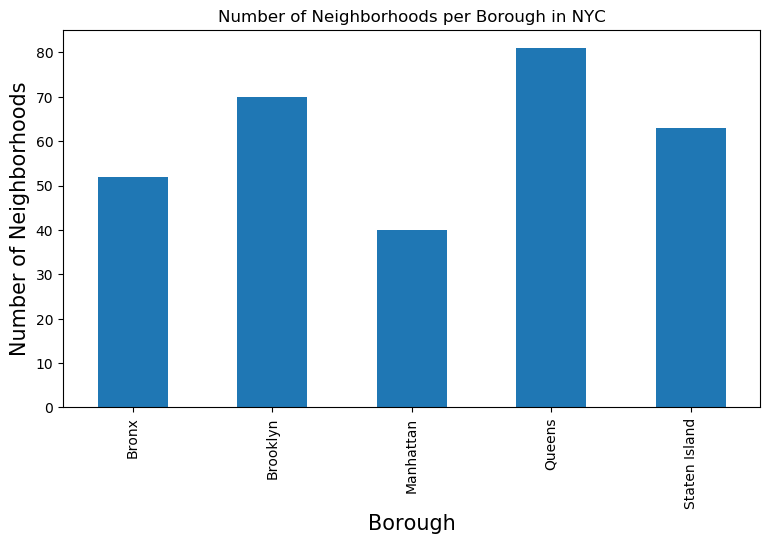

In [4]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhoods per Borough in NYC')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Neighborhoods', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.show()

It is obvious from the bar chart shown above that Borough Queens has the highest number of neighborhoods (around 80) and Manhattan has the loswer (just below 40).

### Creating a map of Queens with neighborhoods superimposed on top

#### Getting the latitude and longitude values for Queens using geopy library

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [6]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_york_data['Latitude'], new_york_data['Longitude'], new_york_data['Borough'], new_york_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Proceeding Further with the analysis

Going further with the analysis by focusing on Queens since it is the Borough with the highest number of neighborhoods. Accordingly, the original dataframe was sliced and created a new dataframe of the Queens data.

In [7]:
queens_data = new_york_data[new_york_data['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


#### Getting the Queens Geographical Coordinates

In [8]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


#### Visualizing the neighborhoods in Queens

In [9]:
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

#### Define Foursquare Credentials and Version

In [10]:
CLIENT_ID = 'U21YTTRRLFQ0XHYECE0YS5243NWGNVLN5AHRTFT0LAIPTFKO' 
CLIENT_SECRET = 'U2MDVGEXPAM0PEGZSDZN03LY213ROB3GUI0NEWH4530N24UI'
VERSION = '20180605'
radius=500
LIMIT=100

#### Explore the first neighborhood

In [11]:
queens_data.loc[0, 'Neighborhood']

'Astoria'

In [12]:
neighborhood_latitude = queens_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queens_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = queens_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Astoria are 40.76850859335492, -73.91565374304234.


In [13]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=U21YTTRRLFQ0XHYECE0YS5243NWGNVLN5AHRTFT0LAIPTFKO&client_secret=U2MDVGEXPAM0PEGZSDZN03LY213ROB3GUI0NEWH4530N24UI&v=20180605&ll=40.76850859335492,-73.91565374304234&radius=500&limit=100'

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ea1c571c94979001bc7c4f4'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Astoria',
  'headerFullLocation': 'Astoria, Queens',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 101,
  'suggestedBounds': {'ne': {'lat': 40.773008597854925,
    'lng': -73.90972309237958},
   'sw': {'lat': 40.76400858885492, 'lng': -73.9215843937051}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bdf502a89ca76b062b75d5e',
       'name': 'Favela Grill',
       'location': {'address': '33-18 28th Ave',
        'crossStreet': 'btwn 33rd & 34th St.',
        'lat': 40.76734843380796,
        'lng': -73.9178974

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\Zia\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Favela Grill,Brazilian Restaurant,40.767348,-73.917897
1,Orange Blossom,Gourmet Shop,40.769856,-73.917012
2,Titan Foods Inc.,Gourmet Shop,40.769198,-73.919253
3,CrossFit Queens,Gym,40.769404,-73.918977
4,Off The Hook,Seafood Restaurant,40.767200,-73.918104


### function for exploring the whole neighborhoods in Queens

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Code to run the above function on each neighborhood and create a new dataframe called queens_venues.

In [20]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [21]:
print(queens_venues.shape)
queens_venues.head()

(2091, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant


In [22]:
queens_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,14,14,14,14,14,14
Auburndale,16,16,16,16,16,16
Bay Terrace,39,39,39,39,39,39
Bayside,74,74,74,74,74,74
Bayswater,2,2,2,2,2,2
Beechhurst,12,12,12,12,12,12
Bellaire,12,12,12,12,12,12


### Analyze Each Neighborhood

In [23]:
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,

It is clear from the table above that there is no Arabian Restaurant in Queens at all. This could be another attractive reason to start up a restaurant which offers arabian foods. 

In [24]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Arverne,0.000000

In [25]:
queens_grouped.describe()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
count,81.000000,81.000000,81.00

However, from the table above (mean values), it is obious that American Restaurant are the most common and popular in different neigbhorhoods.

### Exploring Other Venues

It is important to check other popular venues in order to have an idea about the whole business in different neighborhoods and the crowdness. checking for the best five venues in each neighborhood can provide a conprehensive approach.

In [26]:
num_top_venues = 5

for hood in queens_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = queens_grouped[queens_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
            venue  freq
0       Surf Spot  0.22
1   Metro Station  0.11
2  Sandwich Place  0.11
3           Beach  0.06
4     Coffee Shop  0.06


----Astoria----
                       venue  freq
0                        Bar  0.06
1  Middle Eastern Restaurant  0.06
2                Pizza Place  0.04
3                 Hookah Bar  0.04
4           Greek Restaurant  0.04


----Astoria Heights----
          venue  freq
0  Burger Joint  0.07
1        Bakery  0.07
2   Supermarket  0.07
3    Laundromat  0.07
4          Food  0.07


----Auburndale----
                  venue  freq
0     Mobile Phone Shop  0.06
1     Korean Restaurant  0.06
2        Gymnastics Gym  0.06
3  Fast Food Restaurant  0.06
4          Noodle House  0.06


----Bay Terrace----
                 venue  freq
0       Clothing Store  0.10
1        Women's Store  0.05
2           Donut Shop  0.05
3  American Restaurant  0.05
4           Kids Store  0.05


----Bayside----
                venue  freq
0          

                           venue  freq
0                           Park   1.0
1  Paper / Office Supplies Store   0.0
2                Motorcycle Shop   0.0
3                  Movie Theater   0.0
4                  Moving Target   0.0


----South Jamaica----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.11
1                  Grocery Store  0.11
2           Caribbean Restaurant  0.11
3                         Bakery  0.11
4                    Bus Station  0.11


----South Ozone Park----
                  venue  freq
0                  Park  0.25
1                   Bar  0.17
2  Fast Food Restaurant  0.17
3                 Hotel  0.08
4        Sandwich Place  0.08


----Springfield Gardens----
                 venue  freq
0  Fried Chicken Joint  0.12
1           Donut Shop  0.12
2          Bus Station  0.12
3           Laundromat  0.06
4       Sandwich Place  0.06


----St. Albans----
                  venue  freq
0  Caribbean Restaurant  0.24
1   Fried Chicke

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Sandwich Place,Wine Shop,Playground,Pizza Place,Beach,Thai Restaurant,Board Shop,Coffee Shop
1,Astoria,Bar,Middle Eastern Restaurant,Mediterranean Restaurant,Greek Restaurant,Hookah Bar,Pizza Place,Seafood Restaurant,Bakery,Pub,Café
2,Astoria Heights,Playground,Italian Restaurant,Food,Shopping Mall,Pizza Place,Bowling Alley,Bus Station,Supermarket,Laundromat,Bakery
3,Auburndale,Miscellaneous Shop,Gymnastics Gym,Supermarket,Korean Restaurant,Furniture / Home Store,Discount Store,Athletics & Sports,Toy / Game Store,Italian Restaurant,Noodle House
4,Bay Terrace,Clothing Store,Women's Store,Shoe Store,Mobile Phone Shop,Lingerie Store,Kids Store,Donut Shop,Cosmetics Shop,American Restaurant,Bakery
5,Bayside,Bar,Pizza Place,Sushi Restaurant,Greek Restaurant,American Restaurant,Chinese Restaurant,Indian Restaurant,Mexican Restaurant,Pub,Bakery
6,Bayswater,Park,Playground,Women's Store,Farm,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market
7,Beechhurst,Yoga Studio,Italian Restaurant,Boutique,Supermarket,Optical Shop,Chinese Restaurant,Gym,Gym / Fitness Center,Donut Shop,Dessert Shop
8,Bellaire,Chinese Restaurant,Convenience Store,Italian Restaurant,Breakfast Spot,Moving Target,Bus Station,Laundromat,Grocery Store,Gym,Greek Restaurant
9,Belle Harbor,Beach,Deli / Bodega,Pub,Spa,Mexican Restaurant,Italian Restaurant,Chinese Restaurant,Bakery,Bagel Shop,Donut Shop


We can conclude from the table above that in a lot of neighborhoods, restaurants comes in the first three common categories.

### Cluster Neighborhoods

We have decided to cluster the neighborhoods into four. After that we can choose the best location to open a new Arabian Restaurant.

In [29]:
# set number of clusters
kclusters = 5

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0])

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
queens_merged = queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,0,Bar,Middle Eastern Restaurant,Mediterranean Restaurant,Greek Restaurant,Hookah Bar,Pizza Place,Seafood Restaurant,Bakery,Pub,Café
1,Queens,Woodside,40.746349,-73.901842,0,Grocery Store,Thai Restaurant,Latin American Restaurant,Bakery,Filipino Restaurant,Donut Shop,Bar,American Restaurant,Pub,Ice Cream Shop
2,Queens,Jackson Heights,40.751981,-73.882821,0,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Thai Restaurant,Mobile Phone Shop,Mexican Restaurant,Grocery Store,Pharmacy,Diner
3,Queens,Elmhurst,40.744049,-73.881656,0,Thai Restaurant,Mexican Restaurant,South American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Gym / Fitness Center,Snack Place,Food Court,Malay Restaurant
4,Queens,Howard Beach,40.654225,-73.838138,0,Italian Restaurant,Clothing Store,Pharmacy,Sandwich Place,Bagel Shop,Fast Food Restaurant,Concert Hall,Tapas Restaurant,Mexican Restaurant,Shipping Store


In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a best location for the restaurant to each cluster.

Undoubtedly, cluster one in with the red color is the most condense and logically opening a new restaurant in the middle of it will be vrey appropriate. In fact, there should be other factors taken in consideration before proceeding with such establishment. It seems the location in the middle of the Queens Borough is the best as it looks very desnce with dots and venues where people will be attending relularly and order meals. 

In [32]:
queens_merged.loc[queens_merged['Cluster Labels'] == 0, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Bar,Middle Eastern Restaurant,Mediterranean Restaurant,Greek Restaurant,Hookah Bar,Pizza Place,Seafood Restaurant,Bakery,Pub,Café
1,Woodside,Grocery Store,Thai Restaurant,Latin American Restaurant,Bakery,Filipino Restaurant,Donut Shop,Bar,American Restaurant,Pub,Ice Cream Shop
2,Jackson Heights,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Thai Restaurant,Mobile Phone Shop,Mexican Restaurant,Grocery Store,Pharmacy,Diner
3,Elmhurst,Thai Restaurant,Mexican Restaurant,South American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Gym / Fitness Center,Snack Place,Food Court,Malay Restaurant
4,Howard Beach,Italian Restaurant,Clothing Store,Pharmacy,Sandwich Place,Bagel Shop,Fast Food Restaurant,Concert Hall,Tapas Restaurant,Mexican Restaurant,Shipping Store
5,Corona,Mexican Restaurant,Bakery,Convenience Store,Empanada Restaurant,School,Latin American Restaurant,Donut Shop,Supermarket,Restaurant,Chinese Restaurant
6,Forest Hills,Gym / Fitness Center,Gym,Yoga Studio,Pizza Place,Convenience Store,Park,Thai Restaurant,Pharmacy,Video Game Store,Bank
7,Kew Gardens,Chinese Restaurant,Pharmacy,Pizza Place,Bar,Bank,Indian Restaurant,Park,Cosmetics Shop,Pet Store,Deli / Bodega
8,Richmond Hill,Lounge,Latin American Restaurant,Pizza Place,Bank,Discount Store,Diner,Sandwich Place,Caribbean Restaurant,Moving Target,Chinese Restaurant
9,Flushing,Korean Restaurant,Chinese Restaurant,Hotpot Restaurant,Bakery,Bubble Tea Shop,Karaoke Bar,Hotel,Gym / Fitness Center,Gym,Construction & Landscaping
